# Importando bibliotecas

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sys import stdout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [7]:
# conversor de data
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')
# importação de csv com os dados e indexação deles pela data
data = pd.read_csv('data/transformed/2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
# definição dos tipos de dados
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data.head()

,value,date
index,,
2000-01-01 00:00:00,2422.5,2000-01-01 00:00:00
2000-01-01 01:00:00,2769.3,2000-01-01 01:00:00
2000-01-01 02:00:00,3124.7,2000-01-01 02:00:00
2000-01-01 03:00:00,3154.6,2000-01-01 03:00:00
2000-01-01 04:00:00,3121.8,2000-01-01 04:00:00


# 2. SARIMA

## 2.1 Tratando os dados internos

In [8]:
split_date = '1/1/2021 12:00:00 AM'
test  = data[split_date : ]
train = data['1/12/2020 12:00:00 PM' : split_date]

train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)

series

index
2020-01-12 12:00:00    8079.813
2020-01-12 13:00:00    8206.300
2020-01-12 14:00:00    8198.391
2020-01-12 15:00:00    8248.761
2020-01-12 16:00:00    8241.517
                         ...   
2021-01-30 20:00:00    7217.682
2021-01-30 21:00:00    7187.145
2021-01-30 22:00:00    6658.727
2021-01-30 23:00:00    6529.498
2021-01-31 00:00:00    6279.152
Name: value, Length: 9230, dtype: float64

## 2.2 Métodos para treinamento

In [9]:
# Mostrar previsão de acordo com os dados originais
def plot_forecasts(series, forecasts, test):
	plt.plot(series) # blue

	# Colocando no gráfico as previsões com a cor vermelha
	for i in range(len(forecasts)):
        # Inicio e fim dos dos deslocamentos por x
		off_s = len(series) - len(test) + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]

        # Valores dos multiplos passos de previsão
		yaxis = [series[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')

	# Gráfico
	plt.show()

# Avaliação de erro do SARIMA
def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        ypred_ts = [forecast[i] for forecast in forecasts]
        ytrue_ts = test[i:len(ypred_ts)+i]
        # Calculando os erros
        mape = mean_absolute_percentage_error(ytrue_ts, ypred_ts)*100
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")

    # média dos erros
    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")

# Treinamento de previsão por ARIMA por multiplos passos
def sarima_forecast(train, config, n_steps):
	order, s_order, trend = config
	# Definindo e moldando o modelo
	model = SARIMAX(train, order=order, seasonal_order=s_order, trend=trend, enforce_stationarity=False,
                            enforce_invertibility=False)
	model_fit = model.fit()

	# Fazendo previsão com multiplos passos
	yhat = model_fit.predict(len(train), len(train)+n_steps-1)
	yhat_list = [value for value in yhat]

	return yhat_list

## 2.3 Treinamento e resultado

	t=(697 de 698) -> Predito=5128.416927, Esperado=5425.253000Ultimos 10 valores:
Predito=[9408.731127008465, 9721.387738729478, 10312.010097190156, 10298.385259695013, 10425.57262651028, 10713.100156515511, 11308.514460096945, 11295.401972360616, 11443.768883893375, 11743.642485127404, 12336.817404634503, 12323.77616582515, 12462.001695330084, 12756.187932522686, 13350.974557311523, 13338.406545238635, 13482.205154772651, 13779.747330239223, 14374.252259264074, 14361.971393699065, 14503.51471989474, 14799.907572656608, 15395.077335939533, 15383.177809459961], Esperado=8566.823
Predito=[8434.855916315073, 8790.479024709432, 8652.483062428419, 8291.718091037359, 8321.210320895465, 8779.91140424093, 8694.104651594678, 8172.126317176976, 8117.444124481713, 8522.687969389042, 8409.650186949624, 7967.335836853165, 7954.122706930524, 8385.63659306315, 8285.851665788601, 7803.502367422424, 7769.325071660441, 8187.466013680415, 8080.806480334631, 7618.166615189688, 7594.187085555867, 8018.739781

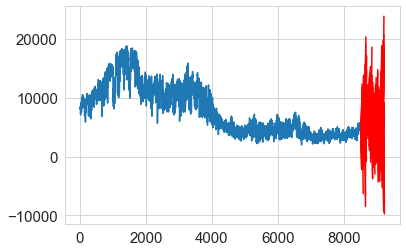

In [10]:
test = test.values
series = series.values
train = [x for x in train]

n_steps = 24

# Ordem de tendencial
p_param = 1
d_param = 1
q_param = 0
# Periodo e ordem sazonal
P_param = 1
D_param = 1
Q_param = 0
m_param = 4
# Tipo de tendencia
t_params = 'ct'  # outros tipos: 'n','c','t','ct'
# configuração
config = [(p_param,d_param,q_param), (P_param,D_param,Q_param,m_param), t_params]

# lista para armazenar os paços de predição e a quantidade de predições a frente
forecasts = list()
forecasts_exp = list()
n_forecasts = len(test) - n_steps + 1

for i in range(n_forecasts):
    # prevendo valor por sarima
    yhat = sarima_forecast(train, config, n_steps)
    # adicionando valor de predição a lista
    forecasts.append(yhat)
    # Adicionando valor de previsão pelo treino para o proximo loop
    obs = test[i]
    train.append(obs)
    forecasts_exp.append([yhat, obs])
    stdout.write("\r\tt=(%i de %i) -> Predito=%f, Esperado=%f" % (i, n_forecasts, yhat[0], obs))

print("Ultimos 10 valores:")
for item in forecasts_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

# Avaliação da previsão
evaluate_forecasts(test, forecasts, n_steps)
# Mostrar previsão
plot_forecasts(series, forecasts, test)